In [1]:
# Import necessary libraries

#!pip install pyspark
#!pip install nltk
#!pip install matplotlib
#!pip install kaggle

import os
import zipfile

import nltk
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt
import random

from pyspark.sql import SparkSession
from pyspark import StorageLevel
from pyspark.sql.functions import col, lower, regexp_replace, trim, rand, udf, size, explode, struct
from pyspark.sql.types import ArrayType, StringType, BooleanType, StructType, StructField, IntegerType, LongType, FloatType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, MinHashLSH
from pyspark.sql.functions import monotonically_increasing_id


nltk.download('stopwords')

print("All libraries imported successfully.")

All libraries imported successfully.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/karankooshavar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# download the dataset from Kaggle if not already present

csv_file = 'Books_rating.csv'
zip_file = 'amazon-books-reviews.zip'

# download and unzip if the final CSV file does not exist

if not os.path.exists(csv_file):

    os.environ['KAGGLE_USERNAME'] = "xxxxxx"
    os.environ['KAGGLE_KEY'] = "xxxxxx"

    !kaggle datasets download -d mohamedbakhet/amazon-books-reviews

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Dataset downloaded and unzipped successfully.")

    os.remove(zip_file)

else:
    print(f"'{csv_file}' already exists. Skipping download and unzip.")

'Books_rating.csv' already exists. Skipping download and unzip.


In [3]:
# Initialize Spark session
# Set the Spark application name and memory configuration

spark = SparkSession.builder \
    .appName("BookReviewSimilarity") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/11 20:10:03 WARN Utils: Your hostname, Karans-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.106 instead (on interface en0)
25/07/11 20:10:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/11 20:10:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:


# loading dataset
DATA_PATH = "Books_rating.csv"
df = spark.read.csv(DATA_PATH, header=True, inferSchema=True)

# specifying the sample size(to be filled manually)
df = df.orderBy(rand(seed=42)).limit(50000)

print(f"Using a sample of {df.count()} rows.")



Using a sample of 50000 rows.


In [5]:
#cleaning the dataset

df = df.na.drop(subset=["Title", "review/text"])

# cleaning Title column

df = df.withColumn('clean_title', lower(col('Title')))
df = df.withColumn('clean_title', regexp_replace('clean_title', r'[^a-z0-9\s]', ''))
df = df.withColumn('clean_title', regexp_replace('clean_title', r'\\s+', ' '))
df = df.withColumn('clean_title', trim(col('clean_title')))


# cleaning Review Text
df = df.withColumn('clean_text', lower(col('review/text')))
df = df.withColumn('clean_text', regexp_replace('clean_text', r'[^a-z\s]', ''))
df = df.withColumn('clean_text', trim(col('clean_text')))


In [6]:
# remove reviews that are only numbers and spaces

print(f"Rows before number-only review filtering: {df.count()}")


df = df.filter(~col("clean_text").rlike("^[\\d\\s]*$"))

print(f"Rows after number-only review filtering: {df.count()}")

Rows before number-only review filtering: 49997


Rows after number-only review filtering: 49923


In [7]:
# tokenize text using Spark's Tokenizer

tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
df = tokenizer.transform(df)

# remove stopwords

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = remover.transform(df)

# stemming 

ps = PorterStemmer()
def stem_text(words):
    if not words:
        return []
    return [ps.stem(word) for word in words]

stem_udf = udf(stem_text, ArrayType(StringType()))
df = df.withColumn("tokens", stem_udf(col("filtered_words")))


25/07/11 20:10:28 WARN StopWordsRemover: Default locale set was [en_IT]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [8]:
# Add a unique identifier to each review row. This is crucial for the self-join later.
df = df.withColumn("review_id", monotonically_increasing_id())

print("Added unique 'review_id' to each row.")

Added unique 'review_id' to each row.


In [9]:

# vectorize the final tokens using CountVectorizer

# removing empty token lists
df = df.filter(size(col('tokens')) > 0)

# vectorize tokens
cv = CountVectorizer(inputCol="tokens", outputCol="features", minDF=2, vocabSize=10000) # Added vocabSize limit
df = cv.fit(df).transform(df)

# function to find zero-vectors (minhash won't work with zero-vectors)

def has_nonzero(v):
    return v is not None and v.numNonzeros() > 0
has_nonzero_udf = udf(has_nonzero, BooleanType())

# remove the found zero-vectors, caching the result

df_clean = df.filter(has_nonzero_udf(col("features"))).persist(StorageLevel.MEMORY_AND_DISK)

print("Rows after strict zero-vector filtering:", df_clean.count())

Rows after strict zero-vector filtering: 49910


In [10]:
# From scratch implementation

# due to limited memmory, can be commented out on better hardware
spark.conf.set("spark.sql.shuffle.partitions", 1000)

# LSH parameters
JACCARD_DISTANCE = 0.6
JACCARD_SIMILARITY = 1 - JACCARD_DISTANCE 
NUM_HASHES = 100
NUM_BANDS = 50
ROWS_PER_BAND = NUM_HASHES // NUM_BANDS

# first prime number larger than the vocabulary
PRIME_P = 10007

# Generate coefficients for our hash functions: h(x) = (a*x + b) % p
random.seed(42)
hash_coeffs_a = [random.randint(1, PRIME_P - 1) for _ in range(NUM_HASHES)]
hash_coeffs_b = [random.randint(0, PRIME_P - 1) for _ in range(NUM_HASHES)]

# Broadcast these small lists to all worker nodes for efficiency
broadcast_hash_coeffs_a = spark.sparkContext.broadcast(hash_coeffs_a)
broadcast_hash_coeffs_b = spark.sparkContext.broadcast(hash_coeffs_b)


# Min-Hash Signature Calculation

# Function to compute Min-Hash signatures for each review
def generate_minhash_signature(feature_vector):
    """
    Takes a sparse feature vector and computes its Min-Hash signature.
    The indices of the vector represent the words (shingles) present in the document.
    """
    signature = [float('inf')] * NUM_HASHES
    

    # makinga standard Python list to avoid serialization errors
    token_indices = feature_vector.indices.tolist()
    
    coeffs_a = broadcast_hash_coeffs_a.value
    coeffs_b = broadcast_hash_coeffs_b.value
    
    for token_index in token_indices:
        for i in range(NUM_HASHES):
            hash_val = (coeffs_a[i] * token_index + coeffs_b[i]) % PRIME_P
            if hash_val < signature[i]:
                signature[i] = hash_val
                
    return signature

minhash_udf = udf(generate_minhash_signature, ArrayType(IntegerType()))

# Add a 'minhash_signature' column to our DataFrame
print("Generating Min-Hash signatures for each review...")
df_signed = df_clean.withColumn("minhash_signature", minhash_udf(col("features")))


# LSH to find Candidate Pairs

# function to create hash buckets for each band of the signature
def create_lsh_bands(signature, review_id):
    """
    Take a Min-Hash signature and split it into bands.
    Hashes each band to a bucket and returns a list of (band_id, hash, review_id).
    """
    bands = []
    for i in range(NUM_BANDS):
        start = i * ROWS_PER_BAND
        end = start + ROWS_PER_BAND
        band_signature = tuple(signature[start:end])
        band_hash = hash((i, band_signature))
        bands.append((i, band_hash, review_id))
    return bands

# Define the schema for the output of the LSH UDF
band_schema = ArrayType(StructType([
    StructField("band_id", IntegerType(), False),
    StructField("band_hash", LongType(), False),
    StructField("review_id", LongType(), False)
]))

lsh_udf = udf(create_lsh_bands, band_schema)

# Create and explode the bands to get one row per band per review
print("Applying LSH banding to find candidate pairs...")
df_banded = df_signed.withColumn("bands", lsh_udf(col("minhash_signature"), col("review_id")))
df_exploded = df_banded.select(explode(col("bands")).alias("band_info"))

# Create a DataFrame with columns: band_id, band_hash, review_id
df_buckets = df_exploded.select(
    col("band_info.band_id").alias("band_id"),
    col("band_info.band_hash").alias("band_hash"),
    col("band_info.review_id").alias("review_id")
)

# Self-join to find reviews that fall into the same bucket in at least one band
df_A = df_buckets.alias("A")
df_B = df_buckets.alias("B")

candidate_pairs_lsh = df_A.join(df_B, on=["band_id", "band_hash"]) \
    .filter(col("A.review_id") < col("B.review_id")) \
    .select(col("A.review_id").alias("id_A"), col("B.review_id").alias("id_B")) \
    .distinct()


# calculate Jaccard Distance

# function to compute Jaccard similarity
def calculate_jaccard(sig1, sig2):
    if not sig1 or not sig2:
        return 0.0
    intersection = sum(1 for i in range(len(sig1)) if sig1[i] == sig2[i])
    return intersection / len(sig1)

jaccard_udf = udf(calculate_jaccard, FloatType())

df_with_sigs_A = df_signed.select(col("review_id").alias("id_A"), col("minhash_signature").alias("sig_A"))
df_with_sigs_B = df_signed.select(col("review_id").alias("id_B"), col("minhash_signature").alias("sig_B"))

# calculate similarity and then distance with the threshold
print(f"Calculating Jaccard Distance and filtering for pairs with distance < {JACCARD_DISTANCE:.2f}...")
candidate_pairs_with_dist = candidate_pairs_lsh \
    .join(df_with_sigs_A, on="id_A") \
    .join(df_with_sigs_B, on="id_B") \
    .withColumn("JaccardSimilarity", jaccard_udf(col("sig_A"), col("sig_B"))) \
    .withColumn("JaccardDistance", 1.0 - col("JaccardSimilarity")) \
    .filter(col("JaccardDistance") < JACCARD_DISTANCE)

# final join to get the original data 
df_hashed = df_clean.select("review_id", "clean_title", "User_id", "review/text")

# Join to get details for review A and B
joined_A = candidate_pairs_with_dist.join(df_hashed.alias("datasetA"), col("id_A") == col("datasetA.review_id"))
joined_AB = joined_A.join(df_hashed.alias("datasetB"), col("id_B") == col("datasetB.review_id"))

# create the 'datasetA' and 'datasetB' structs to match the desired output format
candidate_pairs = joined_AB.select(
    struct(
        col("datasetA.clean_title"),
        col("datasetA.User_id"),
        col("datasetA.review/text"),
        col("datasetA.review_id")
    ).alias("datasetA"),
    struct(
        col("datasetB.clean_title"),
        col("datasetB.User_id"),
        col("datasetB.review/text"),
        col("datasetB.review_id")
    ).alias("datasetB"),
    "JaccardDistance"
).cache()


print(f"Found {candidate_pairs.count()} candidate pairs with Jaccard Distance less than {JACCARD_DISTANCE:.2f}.")

Generating Min-Hash signatures for each review...
Applying LSH banding to find candidate pairs...
Calculating Jaccard Distance and filtering for pairs with distance < 0.60...


Found 3327 candidate pairs with Jaccard Distance less than 0.60.


In [11]:

# tokenize the titles to compare their sets of words

pairs_with_titles = candidate_pairs.withColumn("title_A", col("datasetA.clean_title")) \
                                   .withColumn("title_B", col("datasetB.clean_title"))

# tokenize title columns
title_tokenizer = Tokenizer(outputCol="title_A_tokens")
tokenized_pairs = title_tokenizer.setInputCol("title_A").transform(pairs_with_titles)

title_tokenizer.setOutputCol("title_B_tokens")
tokenized_pairs = title_tokenizer.setInputCol("title_B").transform(tokenized_pairs)


# define and apply a function to check for the subset relationship

def is_subset(list1, list2):
    if not list1 or not list2:
        return False
    set1 = set(list1)
    set2 = set(list2)
    return set1.issubset(set2) or set2.issubset(set1)

is_subset_udf = udf(is_subset, BooleanType())
subset_pairs = tokenized_pairs.withColumn("is_subset_title", is_subset_udf(col("title_A_tokens"), col("title_B_tokens")))


In [12]:
# the final filters

# Filter 1: remove pairs where reviews are identical AND the title is a subset.

almost_final_pairs = subset_pairs.filter(
    (col("JaccardDistance") > 0.0) |
    (col("is_subset_title") == False)
)

# Filter 2: remove pairs where reviews are identical AND from the same user.
final_pairs = almost_final_pairs.filter(
    (col("JaccardDistance") > 0.0) |
    (col("datasetA.User_id") != col("datasetB.User_id"))
).cache()


print(f"Final filtering complete. The 'final_pairs'({final_pairs.count()} rows) DataFrame is ready.")

Final filtering complete. The 'final_pairs'(2419 rows) DataFrame is ready.


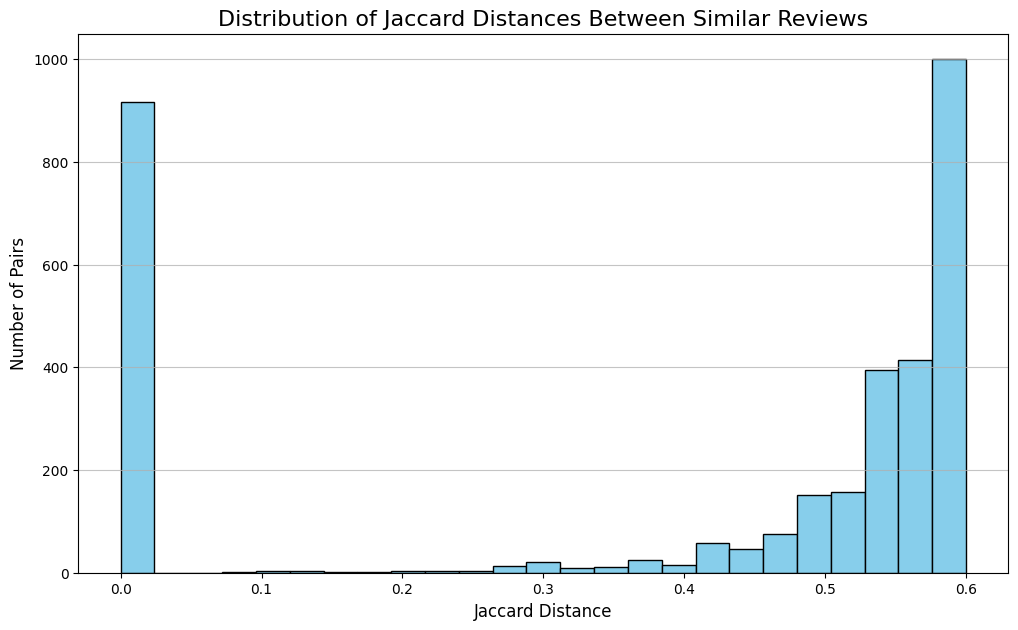

In [13]:
# visualize preliminary results distribution

jaccard_distances_pd1 = candidate_pairs.select("JaccardDistance").toPandas()

plt.figure(figsize=(12, 7))
plt.hist(jaccard_distances_pd1['JaccardDistance'], bins=25, color='skyblue', edgecolor='black')

plt.title('Distribution of Jaccard Distances Between Similar Reviews', fontsize=16)
plt.xlabel('Jaccard Distance', fontsize=12)
plt.ylabel('Number of Pairs', fontsize=12)
plt.grid(axis='y', alpha=0.75)

plt.show()

In [14]:
# show final filtered pairs

interesting_duplicates = subset_pairs.filter(
    (col("JaccardDistance") == 0.0) &
    (col("is_subset_title") == True) &
    (col("datasetA.clean_title") != col("datasetB.clean_title"))
)

interesting_duplicates.select(
    col("datasetA.clean_title").alias("Title_A"),
    col("datasetB.clean_title").alias("Title_B"),
    "is_subset_title",
    "JaccardDistance"
).show(20, truncate=False)


+-------------------------------------------------------------------------------+----------------------------------------------------------------------------------+---------------+---------------+
|Title_A                                                                        |Title_B                                                                           |is_subset_title|JaccardDistance|
+-------------------------------------------------------------------------------+----------------------------------------------------------------------------------+---------------+---------------+
|the outsiders adapted for the stage                                            |the outsiders                                                                     |true           |0.0            |
|the penwyth curse                                                              |penwyth curse the song novels the                                                 |true           |0.0            |
|wuthering heig

In [15]:
# display the final, clean results, sorted by the least similar pairs first

print("\nShowing top candidate pairs found (sorted by least similar first):")

final_pairs.select(
    col("datasetA.clean_title").alias("Title_A"),
    col("datasetB.clean_title").alias("Title_B"),
    col("datasetA.User_id").alias("User_ID_A"),
    col("datasetB.User_id").alias("User_ID_B"),
    col("datasetA.review/text").alias("Original_Review_A"),
    col("datasetB.review/text").alias("Original_Review_B"),
    "JaccardDistance"
).orderBy(col("JaccardDistance").desc()).show(20, truncate=60)


Showing top candidate pairs found (sorted by least similar first):
+------------------------------------------------------------+------------------------------------------------------------+--------------+--------------+------------------------------------------------------------+------------------------------------------------------------+------------------+
|                                                     Title_A|                                                     Title_B|     User_ID_A|     User_ID_B|                                           Original_Review_A|                                           Original_Review_B|   JaccardDistance|
+------------------------------------------------------------+------------------------------------------------------------+--------------+--------------+------------------------------------------------------------+------------------------------------------------------------+------------------+
| the phantom tollbooth gk hall large print for

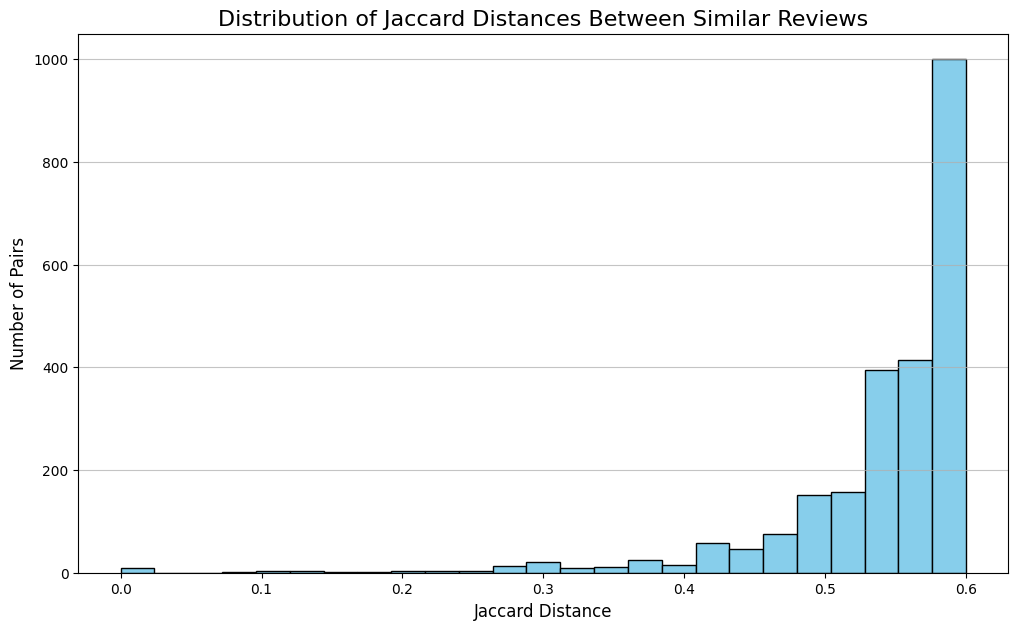

In [16]:
# visualize final results distribution

jaccard_distances_pd = final_pairs.select("JaccardDistance").toPandas()

plt.figure(figsize=(12, 7))
plt.hist(jaccard_distances_pd['JaccardDistance'], bins=25, color='skyblue', edgecolor='black')

plt.title('Distribution of Jaccard Distances Between Similar Reviews', fontsize=16)
plt.xlabel('Jaccard Distance', fontsize=12)
plt.ylabel('Number of Pairs', fontsize=12)
plt.grid(axis='y', alpha=0.75)

plt.show()

In [17]:
# emopty the memory and disk

df_clean.unpersist()
final_pairs.unpersist()
df_clean.unpersist()

print("\nProcessing complete.")


Processing complete.
